In [1]:
import numpy as np 
import matplotlib.pyplot as plt  
import scipy.ndimage as ndi
from sklearn.cluster import KMeans
import skimage.color

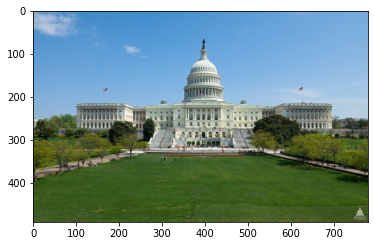

In [2]:
img = plt.imread('capitol.tiff')
plt.imshow(img)

In [3]:
data = img.reshape(img.shape[0] * img.shape[1], 3)
print(img.shape)
print(data.shape)

(492, 780, 3)
(383760, 3)


In [4]:
print(img[0, 20])
print(data[20])

[120 158 203]
[120 158 203]


In [5]:
num_clusters = 3

km = KMeans(num_clusters)
km.fit(data)

KMeans(n_clusters=3)

In [6]:
print(km.cluster_centers_)

[[ 61.88348859  83.66952231  33.37526543]
 [123.6557214  173.68546365 216.7260333 ]
 [135.42675524 140.74583822 129.87031392]]


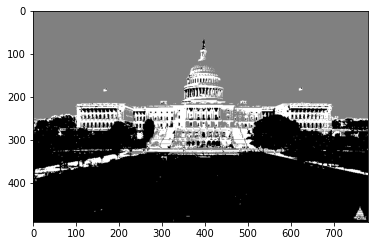

In [7]:
labels = km.predict(data)
img_labels = labels.reshape(img.shape[:2])
plt.imshow(img_labels, 'gray')

In [8]:
''' img_labels_closed = np.zeros((3, 
                              img.shape[0],
                              img.shape[1]))

for label in range(num_clusters):
  img_mask = img_labels == labels 
  img_labels_closed[label] = ndi.binary_closing(img_mask,
                                                iterations = 3)
  
for label in range(num_clusters):
  plt.figure()
  plt.imshow(img_labels_closed[label], 'gray') '''

" img_labels_closed = np.zeros((3, \n                              img.shape[0],\n                              img.shape[1]))\n\nfor label in range(num_clusters):\n  img_mask = img_labels == labels \n  img_labels_closed[label] = ndi.binary_closing(img_mask,\n                                                iterations = 3)\n  \nfor label in range(num_clusters):\n  plt.figure()\n  plt.imshow(img_labels_closed[label], 'gray') "

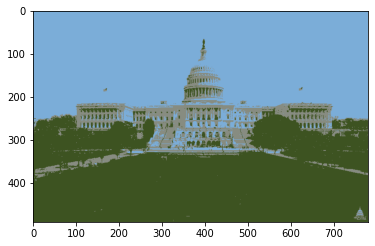

In [10]:
from re import L


img_reconst = np.zeros_like(img)
for label in range(num_clusters):
  img_mask = img_labels == label
  img_reconst[img_mask] = km.cluster_centers_[label]
  
plt.figure()
plt.imshow(img_reconst)

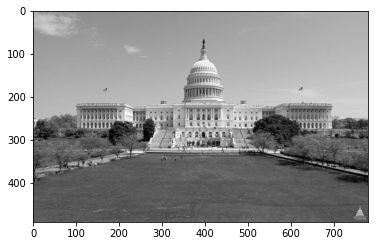

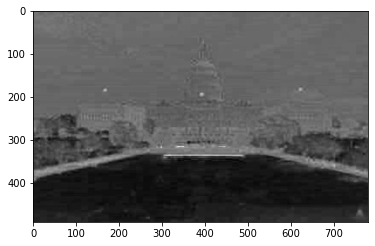

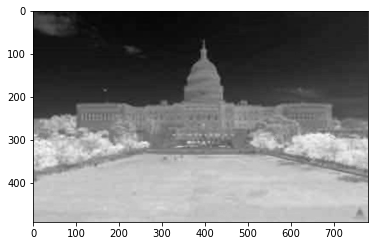

In [11]:
img_lab = skimage.color.rgb2lab(img)
for i in range(3):
  plt.figure()
  plt.imshow(img_lab[:, :, i], 'gray')

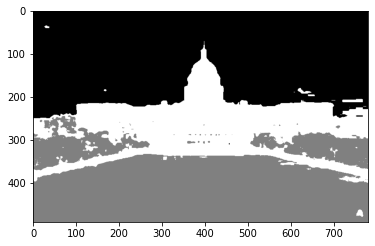

In [17]:
img_ab = img_lab[:, :, 1:]
data = img_ab.reshape(img.shape[0] * img.shape[1], 2)
km = KMeans(n_clusters=3)
km.fit(data)
labels = km.predict(data)
img_labels = labels.reshape(img.shape[:2])
plt.imshow(img_labels, 'gray')

In [13]:
def reconstruct_img_from_lab(img_L, img_labels, clusters_centers):
  img_reconst = np.zeros((img_L.shape[0],
                          img_L.shape[1],
                          3))
  for label in range(len(clusters_centers)):
    ind = np.nonzero(img_labels == label)
    avg_lightness = np.mean(img_L[ind[0], ind[1]])
    img_reconst[ind[0], ind[1], 0] = avg_lightness
    img_reconst[ind[0], ind[1], 1] = clusters_centers[label][0]
    img_reconst[ind[0], ind[1], 2] = clusters_centers[label][1]
  
  img_rgb = skimage.color.lab2rgb(img_reconst)
  
  return img_rgb

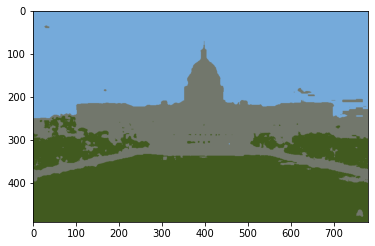

In [18]:
img_rgb = reconstruct_img_from_lab(img_lab[:, :, 0],
                                   img_labels,
                                   km.cluster_centers_)
plt.figure()
plt.imshow(img_rgb)

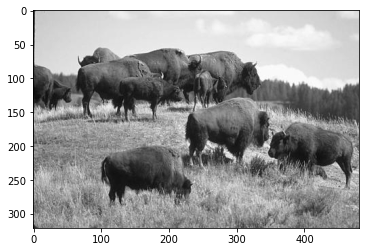

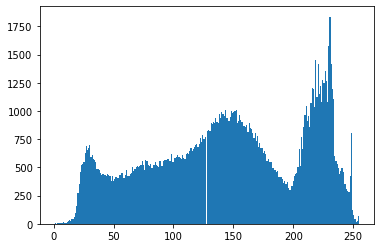

In [19]:
from sklearn.mixture import GaussianMixture

img = plt.imread('gnu.jpg')
plt.imshow(img, 'gray')
plt.figure()
_ = plt.hist(img.ravel(), 256)

In [21]:
from statistics import covariance


gmm = GaussianMixture(n_components=3, 
                      covariance_type = 'spherical')

gmm.fit(img.reshape(-1, 1))

GaussianMixture(covariance_type='spherical', n_components=3)

In [22]:
print(gmm.means_)
print(gmm.covariances_**0.5)
print(gmm.weights_)

[[223.25435072]
 [ 61.6155523 ]
 [146.23018573]]
[12.84091196 27.49766411 28.29622349]
[0.27554636 0.26320691 0.46124673]


In [23]:
def normal_1d(x, mu, variance):
  sigma = variance ** 0.5
  gauss = np.exp(-(x-mu)**2 / (2*sigma**2))
  gauss = gauss / (sigma * np.sqrt(2*np.pi))
  
  return gauss

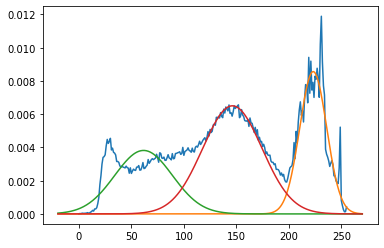

In [25]:
bins = range(257)
hist, _ = np.histogram(img, bins)
prob = (bins[1]-bins[0]) * hist / sum(hist)

averages = gmm.means_
variances = gmm.covariances_
weights = gmm.weights_

bins_models = np.linspace(-20, 270, 500)
prob_classes = []

for c in range(3):
  prob_c = weights[c] * normal_1d(bins_models,
                                  averages[c],
                                  variances[c])
  prob_classes.append(prob_c)
  
plt.plot(bins[:-1], prob)
plt.plot(bins_models, prob_classes[0])
plt.plot(bins_models, prob_classes[1])
plt.plot(bins_models, prob_classes[2])

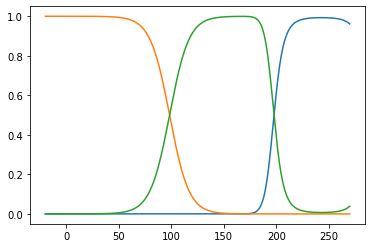

In [27]:
s = prob_classes[0] + prob_classes[1] + prob_classes[2]
for c in range(3):
  plt.plot(bins_models, prob_classes[c] / s)

In [30]:
intensity = 34
ind = np.nonzero((bins_models >= intensity))[0][0]
ind

93

In [31]:
np.digitize([23, 45, 67, 123, 200], bins_models)

array([ 74, 112, 150, 247, 379])

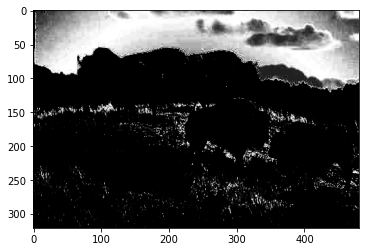

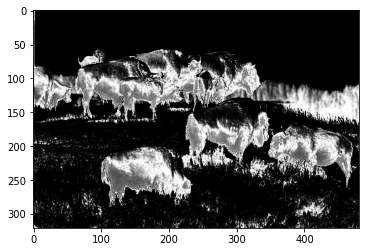

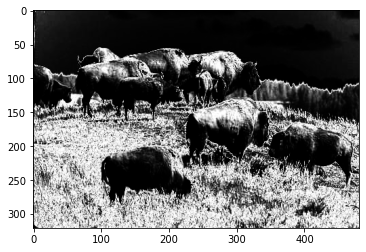

In [32]:
inds = np.digitize(img.ravel(), bins_models)
for c in range(3):
  p = prob_classes[c][inds]
  plt.figure()
  plt.imshow(p.reshape(img.shape), 'gray')  